In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
from src.utils.fileutils import get_project_root
from src.features.soundlevel import soundlevel_for_file

ROOT = get_project_root()
data_root = os.path.join(ROOT, 'data/raw')
audio_root = os.path.join(data_root, 'development_audio/development_audio')


def get_audio_path(scene: str = 'city_center', file_id: str = '09'):
    filename = f'{scene}_{file_id}.wav'
    return os.path.join(audio_root, scene, filename)


def get_soundlevels(audio_path) -> pd.DataFrame:
    df, meta = soundlevel_for_file(audio_path)
    df = df.rename(columns={0: 'dBA'})
    return df, meta


def annotation_heatmap(
    scene: str ='metro_station',
    file_id: str = '04',
    time_res= 1):
    
    _, meta = get_soundlevels(get_audio_path(scene=scene, file_id=file_id))
    
    duration = np.ceil(meta['duration'])
    
    labels_filepath = get_audio_path(scene=scene, file_id=file_id).replace('.wav', '.txt')
    
    df = pd.read_csv(labels_filepath, delimiter='\t', header=None)
    
    timestamps = np.arange(0, duration, time_res)
    ts = pd.DataFrame(timestamps)
    ts = ts.set_index(0)
    
    label_list = df[2].unique()
    
    for label in label_list:
        copy = df[df[2] == label]
        ts[label] = 0
        for row in copy.index: 
            arr = []
            for i in ts.index:
                if i >= copy.loc[row, 0] and i <= copy.loc[row, 1]:
                    arr.append(1)
                else:
                    arr.append(0)

            
            ts[label] = ts[label] + arr

    
    sum_dict = {}
    for col in ts.columns:
        sum_dict[col] = ts[col].sum()

    sorted_dict = dict(sorted(sum_dict.items(), key=lambda item: item[1]))
    sorted_cols = list(sorted_dict.keys())
    
    ts = ts[sorted_cols]
    
    ts.insert(0, 'PLUS_5', ts.pop('PLUS_5'))
    ts.insert(0, 'PLUS_10', ts.pop('PLUS_10'))
    
    
            
    fig, ax = plt.subplots(figsize=(8,5))
    im = ax.imshow(ts.T, aspect='auto', interpolation='none')
    
    # # Create colorbar
    # cbar = ax.figure.colorbar(im, ax=ax)
    # cbar.ax.set_ylabel("", rotation=-90, va="bottom")
    
    ax.set_yticks(np.arange(len(ts.columns)), labels=ts.columns)
    x_labels = np.arange(0, (ts.shape[0]/(1/time_res)), 30)
    # print(ts.shape[0])
    ax.set_xticks(np.arange(0, (ts.shape[0]), 30*(1/time_res)), labels=x_labels)
    
    # Turn spines off and create white grid.
    # ax.spines[:].set_visible(False)
    # ax.set_xticks(np.arange(ts.T.shape[1]+1)-.5, minor=True)
    # ax.set_yticks(np.arange(ts.T.shape[0]+1)-.5, minor=True)
    # ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5) # change the appearance of your padding here
    # ax.tick_params(which="minor", bottom=False, left=False)
    plt.title(f'{scene}_{file_id}.wav')
    plt.tight_layout()
    plt.show()
    plt.close()

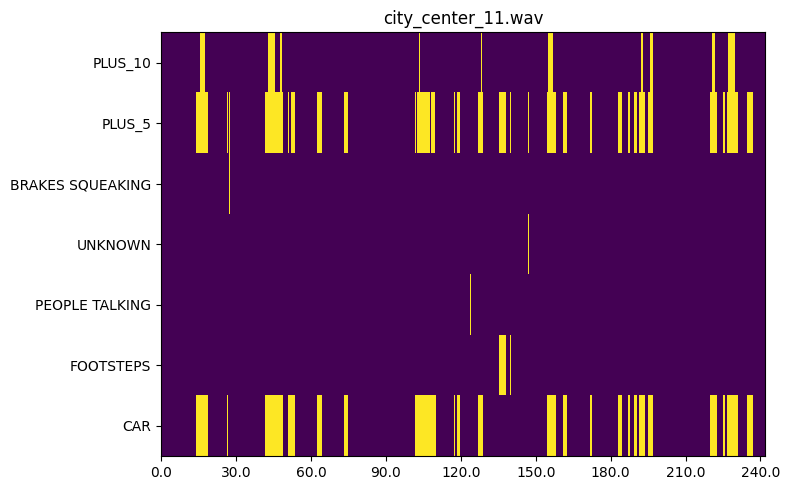

In [2]:
annotation_heatmap(scene='city_center', file_id='11', time_res=0.25)

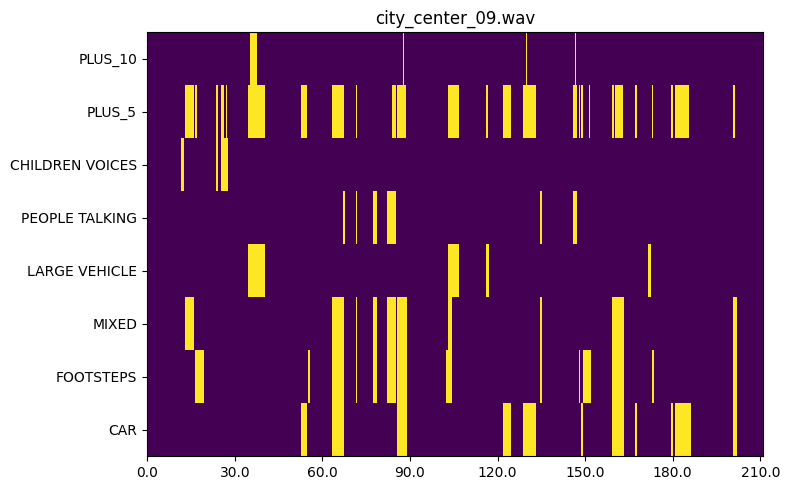

In [3]:
annotation_heatmap(scene='city_center', file_id='09', time_res=0.25)

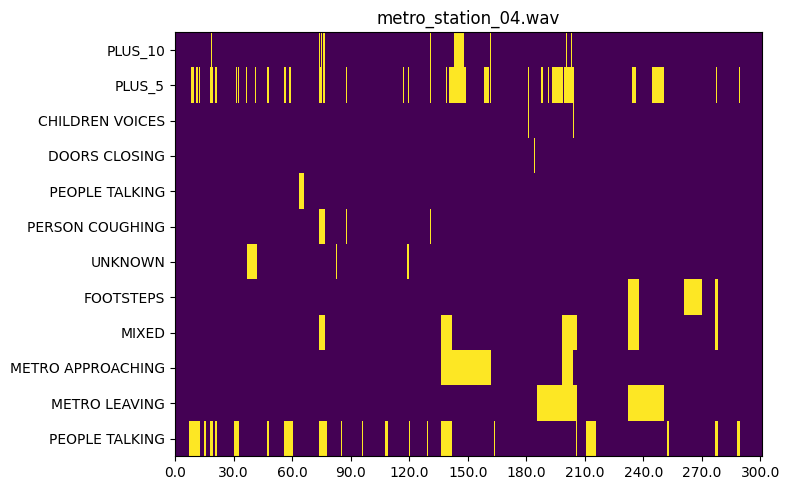

In [4]:
annotation_heatmap(scene='metro_station', file_id='04', time_res=0.25)

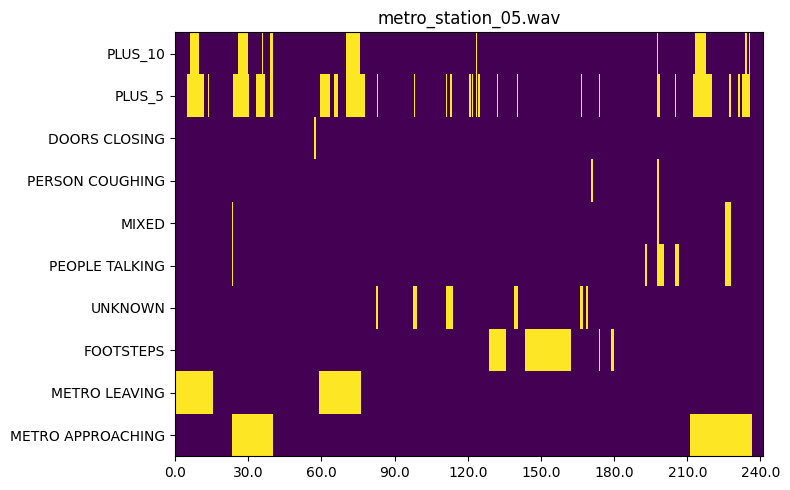

In [5]:
annotation_heatmap(scene='metro_station', file_id='05', time_res=0.25)